In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
from ConvNet import ConvNet
from MLP import MLP
from UNET import UNET
from losses import *
from siren import Siren
from RandomMatrixDataSet import *
torch.random.seed = 1234
plt.rcParams['figure.figsize'] = [14, 6]
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})


#### Testing matrix generation module

In [11]:
N = 2 
E = EigenMatrix(N,mu = 1,sigma = 10)
S = SingularvalueMatrix(N,cond = 10)
M = RandomMatrixDataSet(N)
M.from_eigenvalues(sigma = 1, diagonal = True)
M.get_cond()

array([[3.9673114],
       [4.023678 ]], dtype=float32)

In [3]:
d = 3 #Matrix dimension
cond = 10
# Define model(s) w. hyperparameters
hidden_layers = 5 #Number of hidden layers
hidden_features = 32
kernel_size = 3
filters = 32

#Initate models
reluMLP = MLP(d,hidden_layers, hidden_features)
CNN = ConvNet(hidden_layers,filters,kernel_size)
UNet = UNET(1,1)
SIREN = Siren(d,hidden_features, hidden_layers)


In [4]:
# Initialize network 
model = reluMLP

# Training parameters
loss_fcn = inv_MSE

batch_size = 100
lr = 1e-2
momentum = 0.9
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum = momentum)
k = 10000


In [12]:
# Sample evaluation data with a fixed condition number
X_eval = RandomMatrixDataSet(100, d = d)
#X_eval.from_condition_number(10)
X_eval.from_eigenvalues(sigma = 10, diagonal = True)
x_eval = X_eval.X
y_eval = X_eval.Y

In [6]:
### Training
def train_on_batch(batch, model,loss_fcn, optimizer, scheduler = None):
    pred = model(batch.X)
    if loss_fcn == inv_MSE or loss_fcn == inv_RMSE or loss_fcn == inv_frobenius:
        loss = loss_fcn(pred,batch.X)
    else:
        loss = loss_fcn(pred,batch.Y)

    #Zero the gradient
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

    # Perform a step in LR scheduler to update LR
    if scheduler:
        scheduler.step(loss.item())
    return loss


def run_training(k,model):
    # When a new network is created we init empty training logs
    loss_log = []
    eval_loss_log = []
    weighted_average_log = []
    weighted_average = deque([], maxlen=100)


    # And store the best results
    best_loss = np.inf
    best_model_state_dict = model.state_dict()

    for i in range(k):
        #Sample random matrices with same singular values small condition number
        batch = RandomMatrixDataSet(batch_size, d = d)
        #batch.from_condition_number(cond)
        #Sample random matrices with 
        batch.from_eigenvalues(sigma = 10, diagonal = True)
        
        loss = train_on_batch(batch,model,loss_fcn, optimizer) #/mean_cond  #LOOK IF THIS SHOULD BE REDEFINED


        # We store the model if it has the lowest fitness
        # (this is to avoid losing good results during a run that goes wild)
        if loss < best_loss:
            best_model_state_dict = model.state_dict()
            best_loss = loss
            #print('New Best: ', loss.item())

        # Update the loss trend indicators
        weighted_average.append(loss.item())

        # Update the logs
        weighted_average_log.append(np.mean(weighted_average))
        loss_log.append(loss.item())
        if i % 100 == 0:
            pred_on_eval = model(x_eval)
            eval_loss = loss_fcn(pred_on_eval,x_eval)
            eval_loss_log.append(eval_loss)

        # Print every i iterations
        if i % 1000 == 0:
            wa_out = np.mean(weighted_average)
            print(f"It={i}\t loss={loss.item():.3e}\t  weighted_average={wa_out:.3e}\t eval_loss={eval_loss:.3e}\t")

  
    #def save_results():
    #
    return model,loss_log,weighted_average_log, eval_loss_log

In [7]:
trained_model,loss_log,weighted_average_log,eval_loss_log = run_training(k,model)

It=0	 loss=2.357e+00	  weighted_average=2.357e+00	 eval_loss=1.183e+00	
It=1000	 loss=4.661e-02	  weighted_average=5.641e-02	 eval_loss=6.203e-02	
It=2000	 loss=5.075e-02	  weighted_average=3.901e-02	 eval_loss=4.966e-02	
It=3000	 loss=3.046e-02	  weighted_average=3.081e-02	 eval_loss=3.562e-02	
It=4000	 loss=2.161e-02	  weighted_average=2.501e-02	 eval_loss=3.162e-02	
It=5000	 loss=1.817e-02	  weighted_average=2.256e-02	 eval_loss=2.777e-02	
It=6000	 loss=2.115e-02	  weighted_average=1.905e-02	 eval_loss=2.522e-02	
It=7000	 loss=2.357e-02	  weighted_average=2.164e-02	 eval_loss=2.545e-02	
It=8000	 loss=1.968e-02	  weighted_average=1.649e-02	 eval_loss=2.573e-02	
It=9000	 loss=1.225e-02	  weighted_average=1.895e-02	 eval_loss=2.258e-02	


### Some preliminary results from training. For more eval, see Model_Evaluation.ipynb

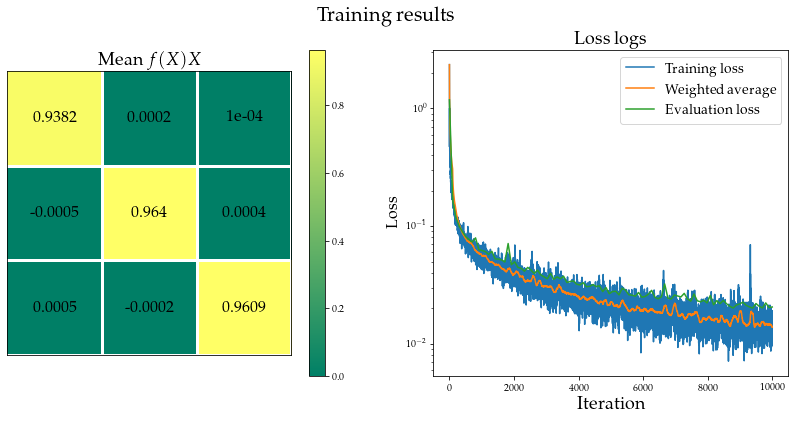

In [10]:
## Inspect if the model overfitted/how it trained on the data.
pred = trained_model(x_eval)

fig = plt.figure()
#Visualize how well the network output serves as an inverse
ax = fig.add_subplot(121)
mean_identity_approx = torch.matmul(pred,x_eval).mean(0)[0].detach().numpy()
img = ax.imshow(mean_identity_approx, cmap = 'summer')
for i in range(d):
        for j in range(d):
            t= ax.text(j, i, round(mean_identity_approx[i, j],4),
                       ha="center", va="center", color="black", fontsize = 16)
# Create colorbar
cbar = ax.figure.colorbar(img, ax=ax)
ax.set_xticks(np.arange(0,3,1)+0.5)
ax.set_yticks(np.arange(0,3,1)+0.5)
ax.set_title('Mean $f(X)X$', fontsize = 18)
ax.set_xticklabels('')
ax.set_yticklabels('')
ax.grid(color="w", linestyle='-', linewidth=3)
ax.tick_params( bottom=False, left=False)

# Plot loss logs
ax = fig.add_subplot(122)
ax.plot(loss_log, label = "Training loss")
ax.plot(weighted_average_log, label = "Weighted average")
ax.plot(np.linspace(0,k,len(eval_loss_log)), eval_loss_log, label= "Evaluation loss")
ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_title('Loss logs', fontsize = 18)
ax.legend(fontsize = 14)
fig.suptitle('Training results', fontsize=20)
ax.set_xlabel('Iteration', fontsize=18)
ylabel = ax.set_ylabel('Loss', fontsize=16)
plt.savefig("training_results_diag.png")